# Image recognition 
Based on tensorflow [tutorial](https://www.tensorflow.org/tutorials/images/hub_with_keras).

## Setup and imports

In [1]:
from __future__ import absolute_import, division, print_function

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import layers

tf.__version__
tf.compat.v1.disable_eager_execution()

Load TensorFlow flowers dataset

In [2]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

Preprocess the dataset to scale input in range [0, 1]

In [3]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root))

Found 3670 images belonging to 5 classes.


Generated image et label batches

In [4]:
for image_batch,label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Labe batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 256, 256, 3)
Labe batch shape:  (32, 5)


## An ImageNet classifier

Load a mobilenet and define the classifier

In [5]:
classifier_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/classification/2" #@param {type:"string"}

def classifier(x):
  classifier_module = hub.Module(classifier_url)
  return classifier_module(x)
  
IMAGE_SIZE = hub.get_expected_image_size(hub.Module(classifier_url))

Show classifier informations

In [6]:
classifier_layer = layers.Lambda(classifier, input_shape = IMAGE_SIZE+[3])
classifier_model = tf.keras.Sequential([classifier_layer])
classifier_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 1001)              0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


Rebuild the data generator with the output size set to match what's expected by the module.

In [7]:
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SIZE)
for image_batch,label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Labe batch shape: ", label_batch.shape)
  break

Found 3670 images belonging to 5 classes.
Image batch shape:  (32, 224, 224, 3)
Labe batch shape:  (32, 5)


Create session to initialize TFHub modules

In [8]:
sess = tf.compat.v1.keras.backend.get_session()
init = tf.compat.v1.global_variables_initializer()

sess.run(init)

Try the model on a single image

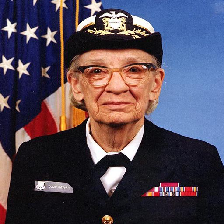

In [9]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SIZE)
grace_hopper 

Scale input in range [0, 1]

In [10]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

Pass the image to the model

In [11]:
result = classifier_model.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

Retrieve the class with the highest probability among the 1001

In [12]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

Fetch the ImageNet labels

In [13]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

Show prediction

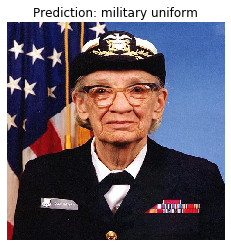

In [14]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name)

Run the classifier on the image batch

In [15]:
result_batch = classifier_model.predict(image_batch)

Predicted outputs

In [16]:
labels_batch = imagenet_labels[np.argmax(result_batch, axis=-1)]
labels_batch

array(['wool', 'picket fence', 'dining table', 'ostrich', 'daisy',
       'daisy', 'cardoon', 'tarantula', 'hip', 'cardoon', 'daisy',
       'daisy', 'picket fence', 'picket fence', 'daisy', 'altar', 'daisy',
       'daisy', 'pot', 'stinkhorn', 'pot', 'picket fence', 'cardoon',
       'daisy', 'daisy', 'picket fence', 'daisy', 'daisy', 'daisy',
       'lakeside', 'lakeside', 'conch'], dtype='<U30')

See if predictions match the images 

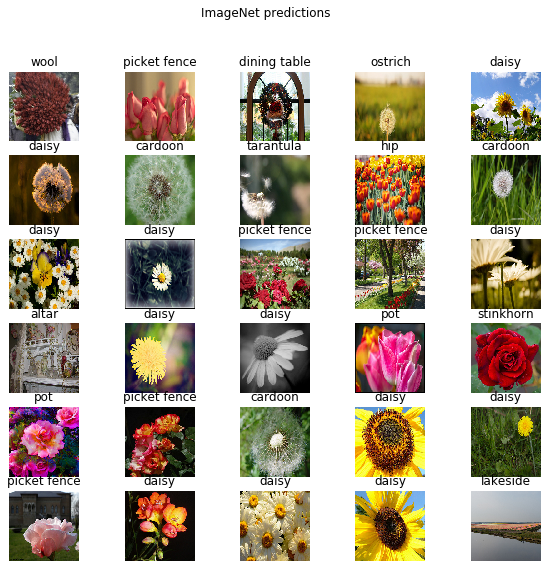

In [17]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(labels_batch[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

## Simple transfer learning

Retrieve headless model, create the module and check the expected image size

In [18]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/2" #@param {type:"string"}

def feature_extractor(x):
  feature_extractor_module = hub.Module(feature_extractor_url)
  return feature_extractor_module(x)

IMAGE_SIZE = hub.get_expected_image_size(hub.Module(feature_extractor_url))

Ensure the data generator is generating images of the expected size

In [19]:
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SIZE)
for image_batch,label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Labe batch shape: ", label_batch.shape)
  break

Found 3670 images belonging to 5 classes.
Image batch shape:  (32, 224, 224, 3)
Labe batch shape:  (32, 5)


Put the module in a keras layer

In [20]:
features_extractor_layer = layers.Lambda(feature_extractor, input_shape=IMAGE_SIZE+[3])

Freeze variables in the feature extractor layer. The training will now only modifies the new classifier layer.

In [21]:
features_extractor_layer.trainable = False

Attach a classification head by wrapping the hub layer in a sequential model. Also add a new classification layer.

In [22]:
model = tf.keras.Sequential([
  features_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 6,405
Trainable params: 6,405
Non-trainable params: 0
_________________________________________________________________


Initialize the TFHub module

In [23]:
init = tf.compat.v1.global_variables_initializer()
sess.run(init)

Test on a single batch and check that the result comes back with the expected shape

In [24]:
result = model.predict(image_batch)
result.shape

(32, 5)

Train the model and compile to configure the training process

In [25]:
model.compile(
  optimizer=tf.compat.v2.keras.optimizers.Adam(), 
  loss='categorical_crossentropy',
  metrics=['accuracy'])

Define a function to collect batch stats

In [26]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []
    
  def on_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['accuracy'])

Train the model.

In [27]:
steps_per_epoch = image_data.samples//image_data.batch_size
batch_stats = CollectBatchStats()
model.fit((item for item in image_data), epochs=1, 
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [batch_stats])

114/114 [==============================] - 258s 2s/step - loss: 0.6914 - accuracy: 0.7504


See the model progress

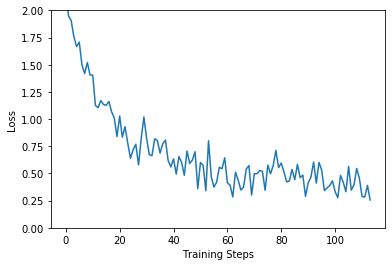

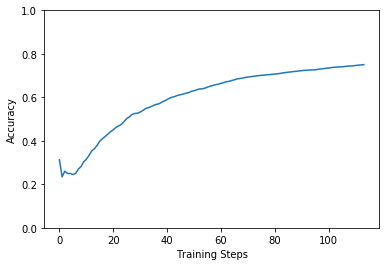

In [28]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats.batch_losses)

plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats.batch_acc)

Retrieve the ordered list of class names:

In [29]:
label_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
label_names = np.array([key.title() for key, value in label_names])
label_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

Pass the image batch through the model and convert the indices to class names

In [30]:
result_batch = model.predict(image_batch)

labels_batch = label_names[np.argmax(result_batch, axis=-1)]
labels_batch

array(['Roses', 'Tulips', 'Daisy', 'Tulips', 'Sunflowers', 'Sunflowers',
       'Dandelion', 'Sunflowers', 'Tulips', 'Dandelion', 'Tulips',
       'Roses', 'Sunflowers', 'Tulips', 'Sunflowers', 'Sunflowers',
       'Sunflowers', 'Tulips', 'Roses', 'Tulips', 'Roses', 'Tulips',
       'Dandelion', 'Dandelion', 'Roses', 'Sunflowers', 'Daisy', 'Daisy',
       'Daisy', 'Dandelion', 'Dandelion', 'Tulips'], dtype='<U10')

Plot result

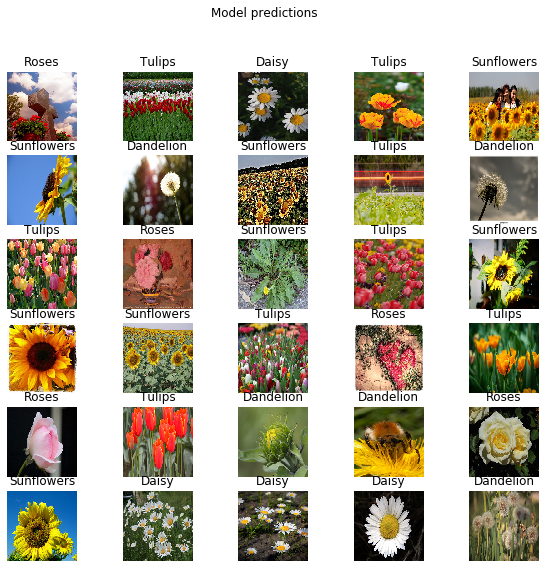

In [31]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(labels_batch[n])
  plt.axis('off')
_ = plt.suptitle("Model predictions")

Export the model

In [32]:
export_path = tf.compat.v1.keras.models.save_model(model, "./saved_models")
export_path